<a href="https://colab.research.google.com/github/alexngocvu/Heart-Disease-and-Lifestyle/blob/main/Trial_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- 1. DATA LOADING ---
Uploading file (heart_2020_cleaned.csv)...


Saving heart_2020_cleaned.csv to heart_2020_cleaned (2).csv
Data shape: (319795, 18)
First 5 rows:
   HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
0           No  16.60     Yes              No     No               3   
1           No  20.34      No              No    Yes               0   
2           No  26.58     Yes              No     No              20   
3           No  24.21      No              No     No               0   
4           No  23.71      No              No     No              28   

   MentalHealth DiffWalking     Sex  AgeCategory   Race Diabetic  \
0            30          No  Female        55-59  White      Yes   
1             0          No  Female  80 or older  White       No   
2            30          No    Male        65-69  White      Yes   
3             0          No  Female        75-79  White       No   
4             0         Yes  Female        40-44  White       No   

  PhysicalActivity  GenHealth  SleepTime Asthma KidneyDise

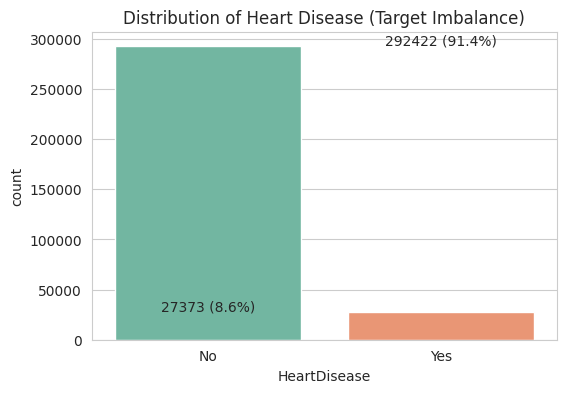

Heart Disease Prevalence: 8.56%
Conclusion: The data is highly **imbalanced**, with Heart Disease 'Yes' cases being only 8.6% of the total. This requires using metrics like AUC and F1-score for evaluation.

--- 3. UNIVARIATE DISTRIBUTIONS (MentalHealth & SleepTime) ---


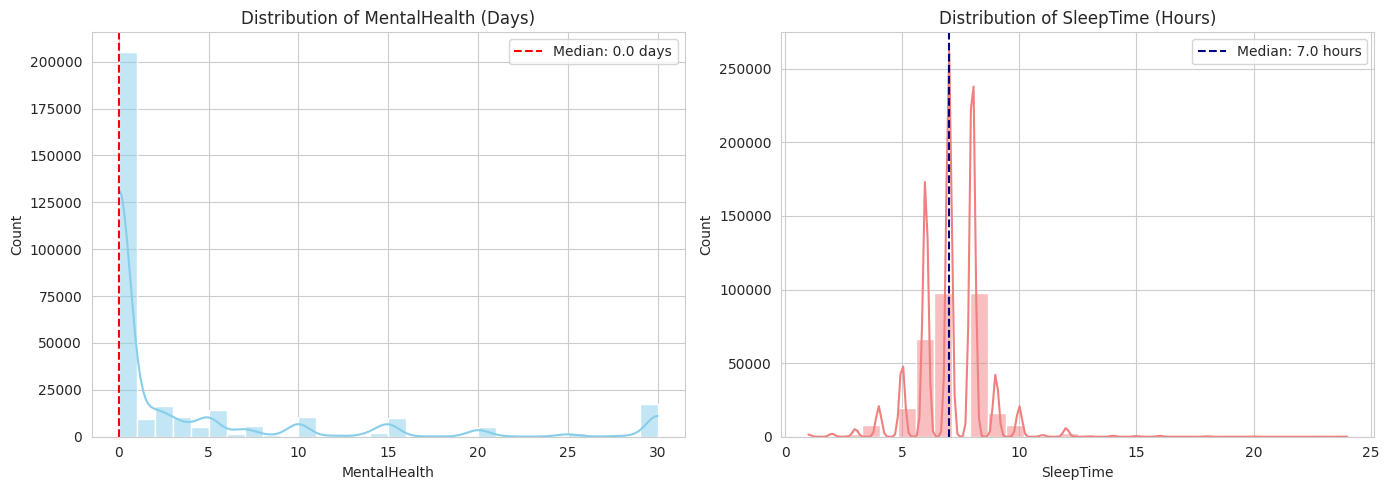

Observation: MentalHealth is **heavily skewed** towards 0. SleepTime shows a relatively normal distribution centered around 7-8 hours.

--- 4. BIVARIATE ANALYSIS (Feature vs. HeartDisease) ---


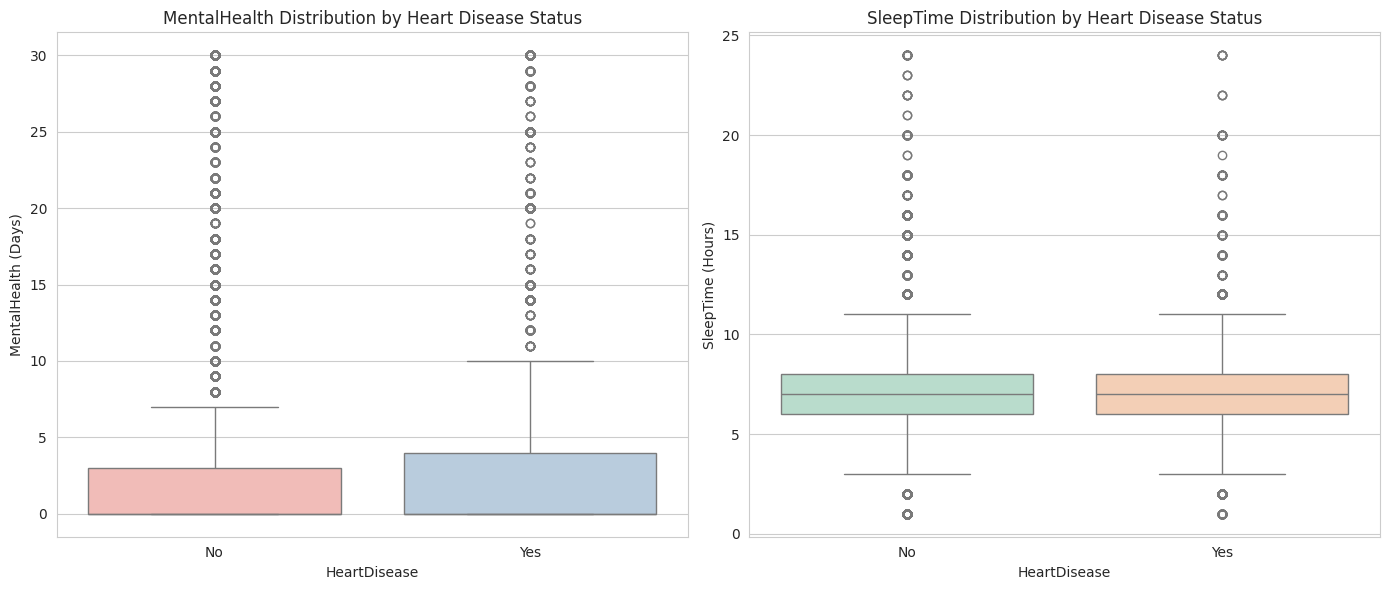

Observation: The median MentalHealth is visibly **higher** for individuals with Heart Disease ('Yes'). The median SleepTime is visibly **lower** for individuals with Heart Disease ('Yes').


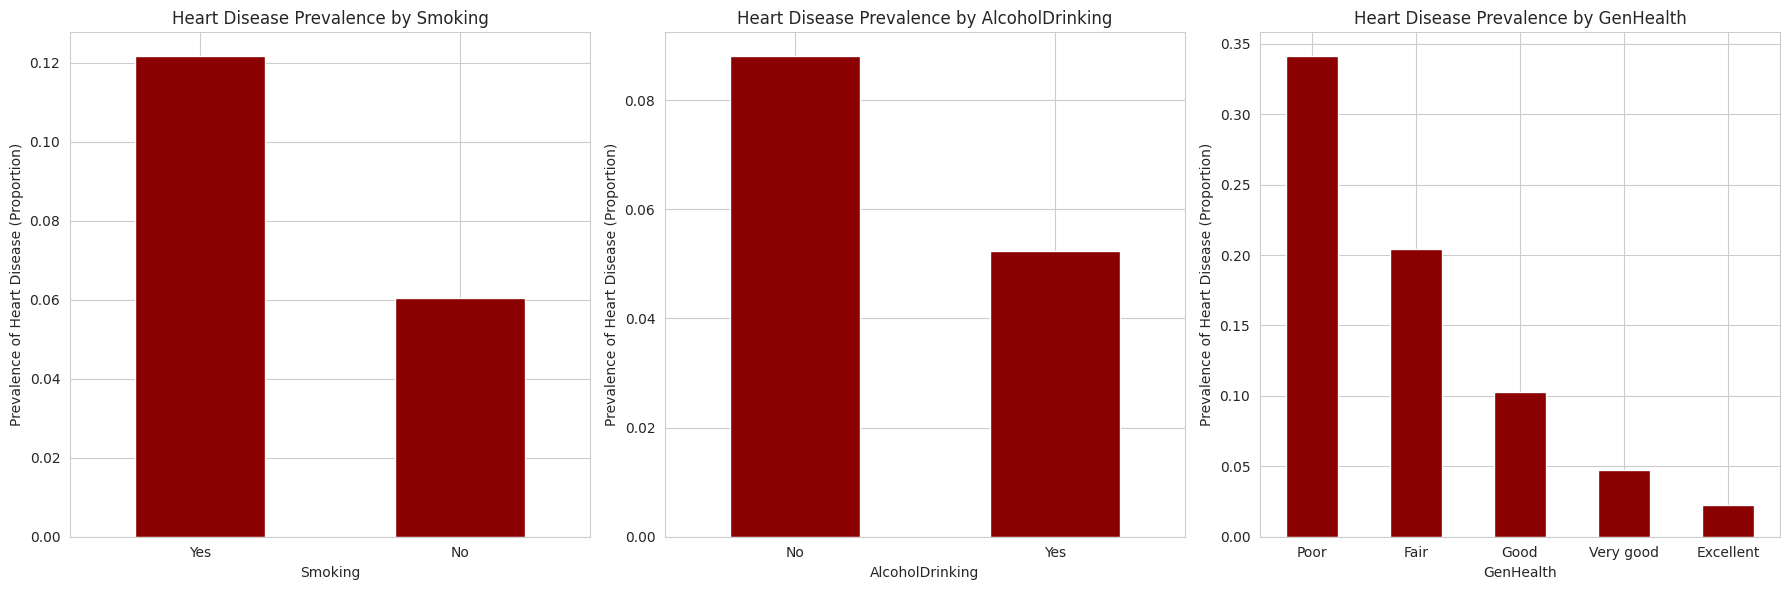

Observation: **Poor/Fair General Health** has a far higher heart disease risk. **Smoking** significantly increases risk. **Alcohol Drinking** appears to slightly decrease or be neutral to risk (note: this is often due to confounding factors in observational data).

--- 5. CORRELATION HEATMAP ---


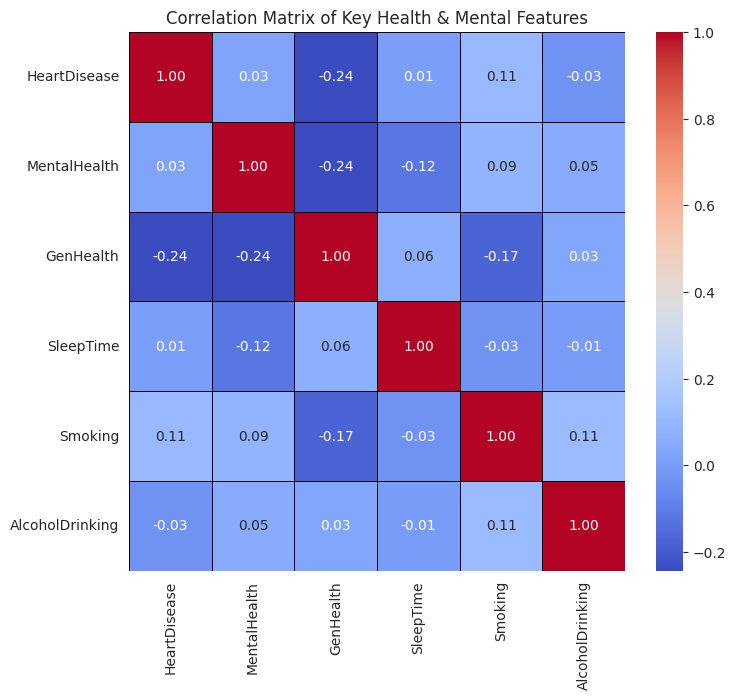


**Key Correlation Findings (HeartDisease row/column):**
HeartDisease       1.000
Smoking            0.108
MentalHealth       0.029
SleepTime          0.008
AlcoholDrinking   -0.032
GenHealth         -0.243
Name: HeartDisease, dtype: float64

Conclusion: **GenHealth** is the strongest predictor (highest positive correlation with encoded GenHealth, meaning Poor health = high risk), followed by Smoking.


In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# --- 1. DATA LOADING ---
print("--- 1. DATA LOADING ---")


try:
    from google.colab import files
    print("Uploading file (heart_2020_cleaned.csv)...")
    uploaded = files.upload()
    df = pd.read_csv('heart_2020_cleaned.csv')
except ImportError:
    # Fallback for local Jupyter/IDE environments
    print("Assuming 'heart_2020_cleaned.csv' is in the current directory.")
    try:
        df = pd.read_csv('heart_2020_cleaned.csv')
    except FileNotFoundError:
        print("ERROR: File not found. Please ensure 'heart_2020_cleaned.csv' is uploaded or in the path.")
        exit()

print(f"Data shape: {df.shape}")
print("First 5 rows:\n", df.head(5))
print("\nData types:\n", df.info(verbose=False))

# Define the features of interest for this specific project
FEATURES = ['HeartDisease', 'MentalHealth', 'GenHealth', 'SleepTime', 'Smoking', 'AlcoholDrinking']
df_eda = df[FEATURES].copy()

# --- 2. TARGET VARIABLE ANALYSIS (Imbalance Check) ---
print("\n--- 2. TARGET IMBALANCE ---")
plt.figure(figsize=(6, 4))
sns.countplot(x='HeartDisease', data=df_eda, palette='Set2')
plt.title('Distribution of Heart Disease (Target Imbalance)')

# Calculate and display percentage
total = len(df_eda)
hd_count = df_eda['HeartDisease'].value_counts()
percent_yes = (hd_count['Yes'] / total) * 100

for i, count in enumerate(hd_count.sort_index(ascending=False)):
    plt.text(i, count + 1000, f"{count} ({count/total:.1%})", ha='center')

plt.show()
print(f"Heart Disease Prevalence: {percent_yes:.2f}%")
print("Conclusion: The data is highly **imbalanced**, with Heart Disease 'Yes' cases being only 8.6% of the total. This requires using metrics like AUC and F1-score for evaluation.")

# --- 3. UNIVARIATE DISTRIBUTIONS ---
print("\n--- 3. UNIVARIATE DISTRIBUTIONS (MentalHealth & SleepTime) ---")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MentalHealth (Days of poor mental health in last 30)
sns.histplot(df_eda['MentalHealth'], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of MentalHealth (Days)')
axes[0].axvline(df_eda['MentalHealth'].median(), color='red', linestyle='--', label=f"Median: {df_eda['MentalHealth'].median():.1f} days")
axes[0].legend()

# SleepTime (Hours)
sns.histplot(df_eda['SleepTime'], bins=30, kde=True, ax=axes[1], color='lightcoral')
axes[1].set_title('Distribution of SleepTime (Hours)')
axes[1].axvline(df_eda['SleepTime'].median(), color='navy', linestyle='--', label=f"Median: {df_eda['SleepTime'].median():.1f} hours")
axes[1].legend()

plt.tight_layout()
plt.show()
print("Observation: MentalHealth is **heavily skewed** towards 0. SleepTime shows a relatively normal distribution centered around 7-8 hours.")

# --- 4. BIVARIATE ANALYSIS (Feature vs. Target) ---
print("\n--- 4. BIVARIATE ANALYSIS (Feature vs. HeartDisease) ---")

# 4.1 Mental Health and Sleep Time vs. Heart Disease
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# MentalHealth
sns.boxplot(x='HeartDisease', y='MentalHealth', data=df_eda, ax=axes[0], palette='Pastel1')
axes[0].set_title('MentalHealth Distribution by Heart Disease Status')
axes[0].set_xlabel('HeartDisease')
axes[0].set_ylabel('MentalHealth (Days)')

# SleepTime
sns.boxplot(x='HeartDisease', y='SleepTime', data=df_eda, ax=axes[1], palette='Pastel2')
axes[1].set_title('SleepTime Distribution by Heart Disease Status')
axes[1].set_xlabel('HeartDisease')
axes[1].set_ylabel('SleepTime (Hours)')

plt.tight_layout()
plt.show()
print("Observation: The median MentalHealth is visibly **higher** for individuals with Heart Disease ('Yes'). The median SleepTime is visibly **lower** for individuals with Heart Disease ('Yes').")

# 4.2 Categorical Features (Smoking, Alcohol, GenHealth) vs. Heart Disease Prevalence
categorical_features = ['Smoking', 'AlcoholDrinking', 'GenHealth']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, feature in enumerate(categorical_features):
    # Calculate proportion of HeartDisease=Yes for each category
    ctab = pd.crosstab(df_eda[feature], df_eda['HeartDisease'], normalize='index')
    # Plot only the 'Yes' prevalence
    ctab['Yes'].sort_values(ascending=False).plot(kind='bar', ax=axes[i], color='darkred')
    axes[i].set_title(f'Heart Disease Prevalence by {feature}')
    axes[i].set_ylabel('Prevalence of Heart Disease (Proportion)')
    axes[i].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()
print("Observation: **Poor/Fair General Health** has a far higher heart disease risk. **Smoking** significantly increases risk. **Alcohol Drinking** appears to slightly decrease or be neutral to risk (note: this is often due to confounding factors in observational data).")


# --- 5. CORRELATION HEATMAP ---
print("\n--- 5. CORRELATION HEATMAP ---")

# Preprocessing for correlation matrix (creating numeric representation)
df_corr = df_eda.copy()
df_corr['HeartDisease'] = df_corr['HeartDisease'].map({'Yes': 1, 'No': 0})
df_corr['Smoking'] = df_corr['Smoking'].map({'Yes': 1, 'No': 0})
df_corr['AlcoholDrinking'] = df_corr['AlcoholDrinking'].map({'Yes': 1, 'No': 0})

# Ordinal Encoding for GenHealth
genhealth_order = ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']
genhealth_map = {val: idx for idx, val in enumerate(genhealth_order)}
df_corr['GenHealth'] = df_corr['GenHealth'].map(genhealth_map)

# Compute correlation matrix
corr_matrix = df_corr.corr()

plt.figure(figsize=(8, 7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5, linecolor='black')
plt.title('Correlation Matrix of Key Health & Mental Features')
plt.show()

print("\n**Key Correlation Findings (HeartDisease row/column):**")
print(corr_matrix['HeartDisease'].sort_values(ascending=False).round(3))
print("\nConclusion: **GenHealth** is the strongest predictor (highest positive correlation with encoded GenHealth, meaning Poor health = high risk), followed by Smoking.")


RANDOM FOREST CLASSIFICATION PIPELINE
Data split successfully. Training on 255836 samples.

--- 3. MODEL TRAINING ---
Random Forest Model Trained and Fitted.

--- 4. MODEL EVALUATION ---

Classification Report:
              precision    recall  f1-score   support

       No HD       0.96      0.67      0.79     58484
      Has HD       0.16      0.69      0.26      5475

    accuracy                           0.67     63959
   macro avg       0.56      0.68      0.53     63959
weighted avg       0.89      0.67      0.74     63959

Area Under the ROC Curve (AUC-ROC): 0.7440
Note: AUC-ROC is the best metric for imbalanced classification performance.


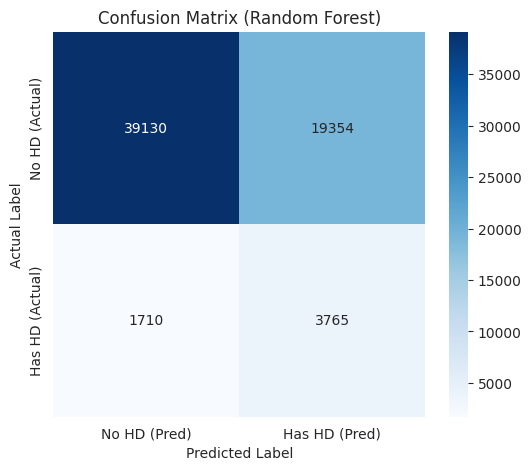


--- 5. FEATURE IMPORTANCE ---
           Feature  Importance
4        GenHealth    0.727096
1          Smoking    0.106883
3     MentalHealth    0.080362
0        SleepTime    0.066620
2  AlcoholDrinking    0.019038


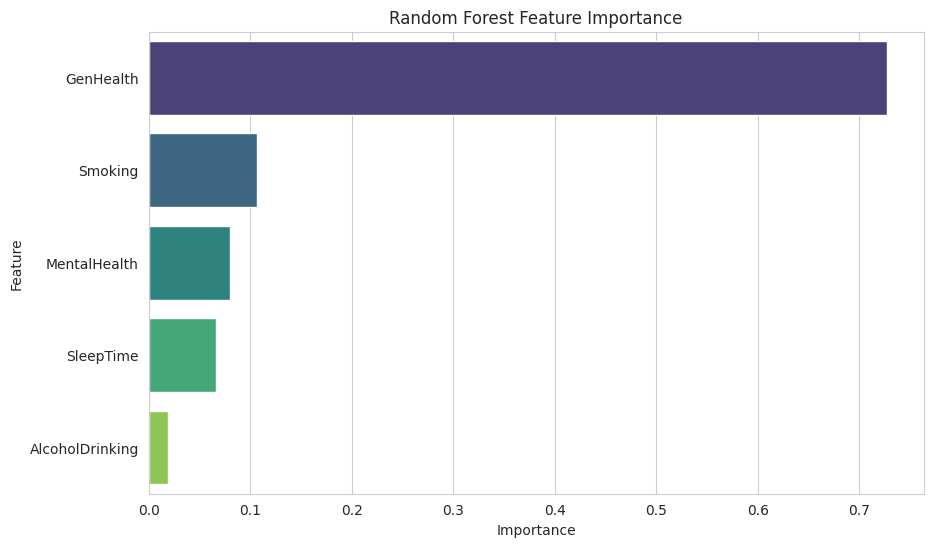


Mental Health Importance Score (Random Forest): 0.0804
This score quantifies the non-linear predictive power of Mental Health relative to other features in the model.


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


print("\n" + "="*50)
print("RANDOM FOREST CLASSIFICATION PIPELINE")
print("="*50)

# --- 1. DATA PREPROCESSING FOR MODELING ---
FEATURES = ['SleepTime', 'Smoking', 'AlcoholDrinking', 'MentalHealth', 'GenHealth']
TARGET = 'HeartDisease'

# Create a clean DataFrame copy
df_model = df[FEATURES + [TARGET]].copy()

# A. Convert Target (HeartDisease)
df_model[TARGET] = df_model[TARGET].map({'Yes': 1, 'No': 0})

# B. Convert Binary Features (Smoking, AlcoholDrinking)
for col in ['Smoking', 'AlcoholDrinking']:
    df_model[col] = df_model[col].map({'Yes': 1, 'No': 0})

# C. Ordinal Encode GenHealth (Crucial: Poor=0, Excellent=4)
genhealth_order = ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']
genhealth_map = {val: idx for idx, val in enumerate(genhealth_order)}
df_model['GenHealth'] = df_model['GenHealth'].map(genhealth_map)

# Handle Missing Values (if any)
df_model.dropna(inplace=True)

# Separate features (X) and target (y)
X = df_model[FEATURES]
y = df_model[TARGET]

# Scaling: While Random Forest doesn't require scaling, it's good practice
# and keeps the pipeline consistent if you later switch to models like SVM/LogReg.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=FEATURES, index=X.index)


# --- 2. TRAIN-TEST SPLIT ---
# Stratified split is vital due to the severe class imbalance (8.6% prevalence)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Data split successfully. Training on {X_train.shape[0]} samples.")


# --- 3. RANDOM FOREST MODEL TRAINING ---
print("\n--- 3. MODEL TRAINING ---")

# Initialize Model with Balanced Class Weight
# 'balanced' class_weight adjusts the training process to give more importance
# to the minority class ('HeartDisease'=1) to improve Recall.
rf_model = RandomForestClassifier(
    n_estimators=200,          # Number of trees
    max_depth=10,              # Regularization parameter
    random_state=42,
    class_weight='balanced',   # CRITICAL for imbalanced data
    n_jobs=-1                  # Use all available cores
)

# Train the model
rf_model.fit(X_train, y_train)
print("Random Forest Model Trained and Fitted.")


# --- 4. MODEL EVALUATION ---
print("\n--- 4. MODEL EVALUATION ---")

# Predict and Get Probabilities
y_pred = rf_model.predict(X_test)
# Probability of the positive class (Heart Disease = 1) is used for AUC-ROC
y_proba = rf_model.predict_proba(X_test)[:, 1]

# Key Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No HD', 'Has HD']))

auc_score = roc_auc_score(y_test, y_proba)
print(f"Area Under the ROC Curve (AUC-ROC): {auc_score:.4f}")
print("Note: AUC-ROC is the best metric for imbalanced classification performance.")

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No HD (Pred)', 'Has HD (Pred)'],
            yticklabels=['No HD (Actual)', 'Has HD (Actual)'])
plt.title('Confusion Matrix (Random Forest)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


# --- 5. FEATURE IMPORTANCE (The Answer to R.Q. 1) ---
print("\n--- 5. FEATURE IMPORTANCE ---")

# Extract Importance
importances = rf_model.feature_importances_
feature_names = X_scaled_df.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

# Visualize Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Random Forest Feature Importance')
plt.show()

# Final Check on Mental Health's Importance
mental_health_importance = feature_importance_df[feature_importance_df['Feature'] == 'MentalHealth']['Importance'].iloc[0]
print(f"\nMental Health Importance Score (Random Forest): {mental_health_importance:.4f}")
print("This score quantifies the non-linear predictive power of Mental Health relative to other features in the model.")

--- 1. DATA LOADING & PREP ---
Data prepared and scaled. Total samples: 319795

--- 2. OPTIMAL K DETERMINATION ---


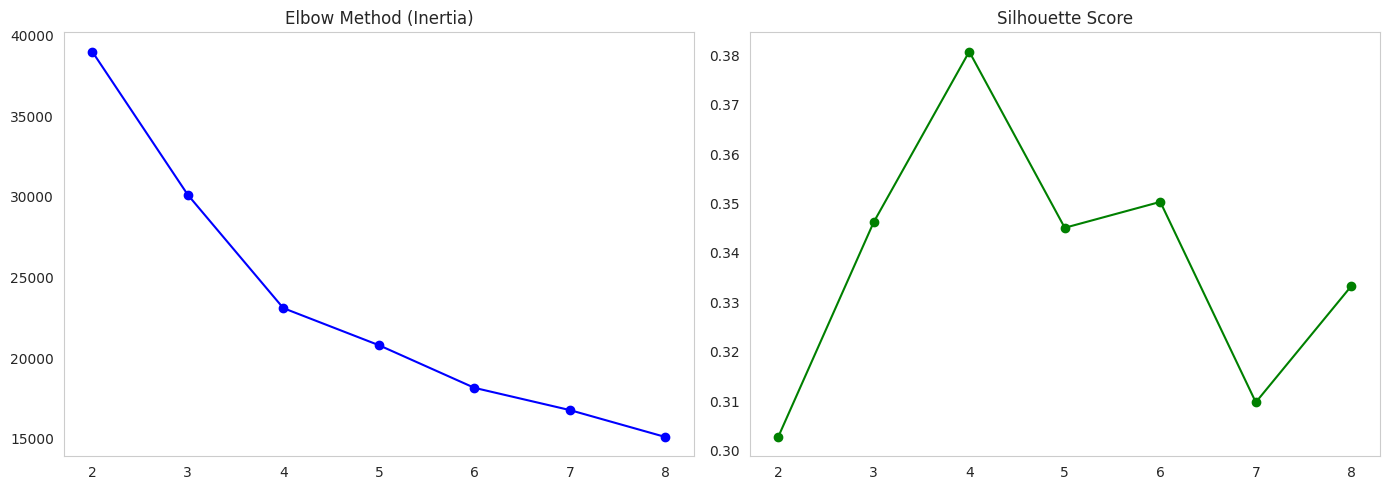


--- 3. CLUSTERING AND PROFILING ---
Using optimal k = 4 for final clustering.

--- CLUSTER PROFILES (Risk Groups) ---
Note: Mean values for binary features (Smoking/Alcohol) represent the proportion of 'Yes'.
         SleepTime  Smoking  AlcoholDrinking  MentalHealth  GenHealth  \
Cluster                                                                 
1            6.531    0.523              0.0        24.291      1.718   
2            7.139    1.000              0.0         1.399      2.482   
3            7.181    0.000              0.0         1.414      2.815   
0            7.071    0.616              1.0         5.405      2.710   

         HeartDisease_Prevalence GenHealth_Desc  
Cluster                                          
1                          0.130           Good  
2                          0.122           Good  
3                          0.059      Very good  
0                          0.052      Very good  


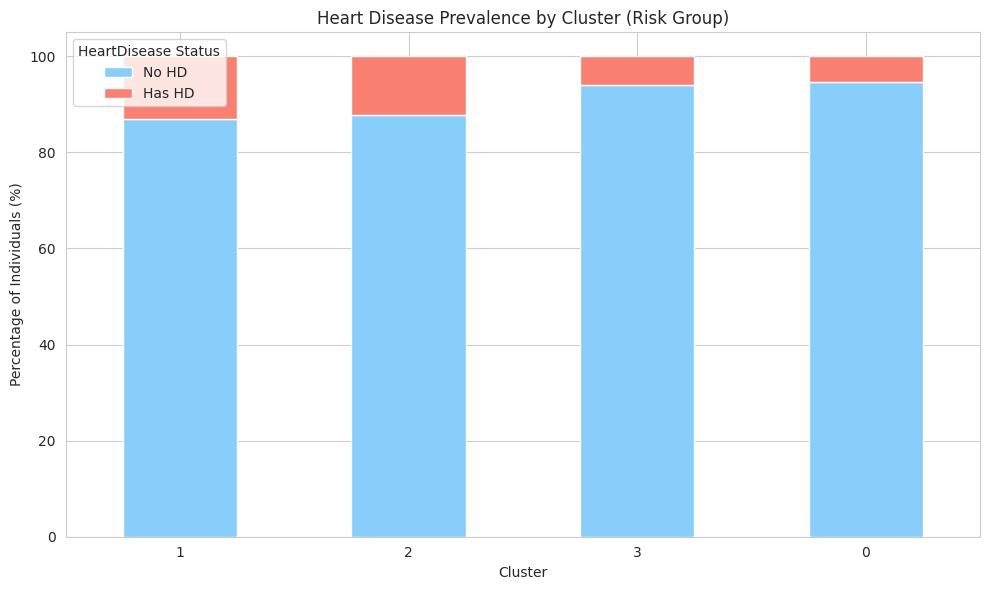

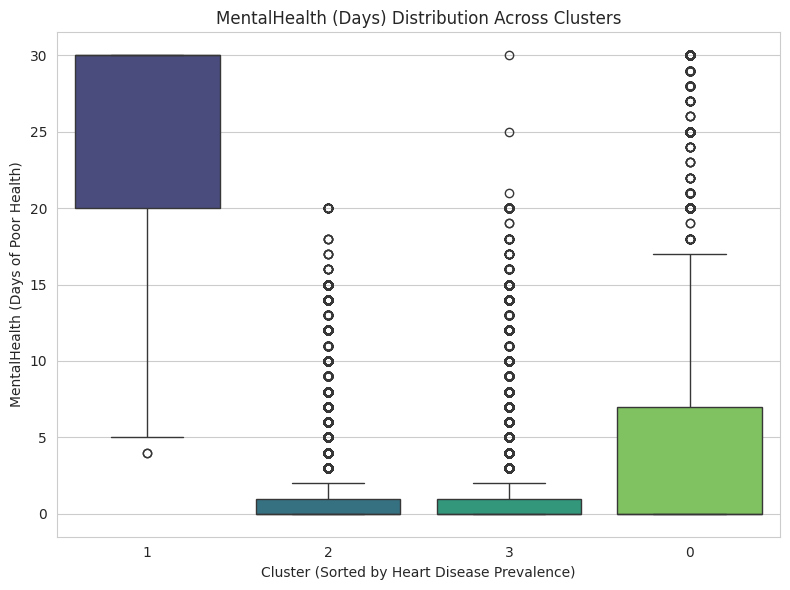

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Modules for Preprocessing and Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

# Define Features and Target
FEATURES = ['SleepTime', 'Smoking', 'AlcoholDrinking', 'MentalHealth', 'GenHealth']
TARGET = 'HeartDisease'

# --- 1. DATA LOADING AND PREPROCESSING ---
print("--- 1. DATA LOADING & PREP ---")

# Load the data (Must be executed in your Colab environment)
try:
    df = pd.read_csv('heart_2020_cleaned.csv')
except FileNotFoundError:
    print("ERROR: File 'heart_2020_cleaned.csv' not found. Please ensure it is loaded.")
    exit()

# Create a master processed DataFrame copy
df_clust = df[FEATURES + [TARGET]].copy()

# A. Ordinal Encoding for GenHealth (Poor=0, Excellent=4)
genhealth_order = ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']
genhealth_map = {val: idx for idx, val in enumerate(genhealth_order)}
df_clust['GenHealth'] = df_clust['GenHealth'].map(genhealth_map)
genhealth_words = {idx: val for val, idx in genhealth_map.items()} # Map for reverse lookup

# B. Convert Binary Features and Target to numeric (0/1)
for col in ['Smoking', 'AlcoholDrinking']:
    df_clust[col] = df_clust[col].map({'Yes': 1, 'No': 0})
df_clust[TARGET] = df_clust[TARGET].map({'Yes': 1, 'No': 0})

# Handle Missing Values
df_clust.dropna(inplace=True)

X = df_clust[FEATURES]
y = df_clust[TARGET]

# C. Scaling (CRITICAL for distance-based clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=FEATURES, index=X.index)
print(f"Data prepared and scaled. Total samples: {X_scaled_df.shape[0]}")


# --- 2. DETERMINING OPTIMAL K (Elbow and Silhouette Methods) ---
print("\n--- 2. OPTIMAL K DETERMINATION ---")

# Use a stratified sample of 10,000 points for efficiency
np.random.seed(42)
K_range = range(2, 9)
X_sample = X_scaled_df.sample(n=10000, random_state=42)

inertias = []
sil_scores = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
    kmeans.fit(X_sample)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_sample, kmeans.labels_))
    # print(f"k={k} → Silhouette: {sil_scores[-1]:.3f}") # Optionally print scores

# Plotting metrics (kmeans_metrics.png equivalent)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(K_range, inertias, 'bo-'); axes[0].set_title('Elbow Method (Inertia)'); axes[0].grid()
axes[1].plot(K_range, sil_scores, 'go-'); axes[1].set_title('Silhouette Score'); axes[1].grid()
plt.tight_layout()
plt.show()


# --- 3. FINAL CLUSTERING AND PROFILING ---
print("\n--- 3. CLUSTERING AND PROFILING ---")

optimal_k = 4 # Choose k based on the plots (assuming 4 provides good interpretability)
print(f"Using optimal k = {optimal_k} for final clustering.")

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled_df)

df_clustered = df_clust.copy() # Use unscaled data for interpretation
df_clustered['Cluster'] = cluster_labels

# Create Cluster Profiles (Mean values of UNCALED features)
cluster_profile = df_clustered.groupby('Cluster')[FEATURES + [TARGET]].mean()
cluster_profile['GenHealth_Desc'] = cluster_profile['GenHealth'].round(0).astype(int).map(genhealth_words)
cluster_profile.rename(columns={TARGET: 'HeartDisease_Prevalence'}, inplace=True)
cluster_profile.sort_values(by='HeartDisease_Prevalence', ascending=False, inplace=True)

print("\n--- CLUSTER PROFILES (Risk Groups) ---")
print("Note: Mean values for binary features (Smoking/Alcohol) represent the proportion of 'Yes'.")
print(cluster_profile.round(3))


# --- 4. VISUALIZATION OF RISK (Prevalence and Mental Health) ---

# A. Heart Disease Prevalence by Cluster
ctab = pd.crosstab(df_clustered['Cluster'], df_clustered[TARGET], normalize='index') * 100
ctab.columns = ['No HD', 'Has HD']
ctab_sorted = ctab.sort_values(by='Has HD', ascending=False)

plt.figure(figsize=(10, 6))
ctab_sorted.plot(kind='bar', stacked=True, color=['lightskyblue', 'salmon'], ax=plt.gca())
plt.title('Heart Disease Prevalence by Cluster (Risk Group)')
plt.ylabel('Percentage of Individuals (%)')
plt.xticks(rotation=0)
plt.legend(title='HeartDisease Status')
plt.tight_layout()
plt.show()

# B. Mental Health Distribution across Clusters (Box Plot)
plt.figure(figsize=(8, 6))
sns.boxplot(x='Cluster', y='MentalHealth', data=df_clustered,
            order=ctab_sorted.index, palette='viridis')
plt.title('MentalHealth (Days) Distribution Across Clusters')
plt.xlabel(f'Cluster (Sorted by Heart Disease Prevalence)')
plt.ylabel('MentalHealth (Days of Poor Health)')
plt.tight_layout()
plt.show()